In [264]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim

pd.set_option('display.max_columns', 200)

# Load dataset

In [2]:
param_list = pd.read_csv("./parameter_list.csv")
param_list

,parameter_name,unit_type,input_output,engine_aircraft,table_name,data_type,alias,creator,param_description,display_format,display_length,display_decimals,justification
0,ACTTIMH,MISCELLANEOUS,IN,AIRCRAFT,AIRCRAFT_INPUT,FLOAT,ACTTIMH,AIRLINE,A/C TOTAL TIME(HOURS/MIN),NONE,10,3,L
1,AGW,MASS (CONVERTED),IN,AIRCRAFT,AIRCRAFT_INPUT,FLOAT,ACTUAL_GROSS_WEIGHT,AIRLINE,ACTUAL GROSS WEIGHT (LB),NONE,10,3,L
2,AILTRIM,MISCELLANEOUS,IN,AIRCRAFT,AIRCRAFT_INPUT,FLOAT,AILTRIM,AIRLINE,AILERON TRIM (DEG),NONE,10,3,L
3,AIRID,MISCELLANEOUS,IN,AIRCRAFT,AIRCRAFT_INPUT,CHAR,AIRID,GECFMI,AIRCRAFT ID,NONE,10,3,L
4,ALLSAPL,MISCELLANEOUS,IN,AIRCRAFT,AIRCRAFT_INPUT,FLOAT,ALLSAPL,AIRLINE,ALL SPEED AILERON POS LH,NONE,10,3,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,ZWBP3,MASS (CONVERTED),IN,AIRCRAFT,AIRCRAFT_INPUT,FLOAT,ECS_PACK_3_FLOW_PER_SEC,GECFMI,PACK FLOW 3,NONE,10,3,L
352,ZWF36,MASS (CONVERTED),IN,ENGINE,ENGINE_INPUT,FLOAT,FUEL_FLOW_(PER_HOUR),GECFMI,FUEL FLOW,NONE,10,3,L
353,ZWF36_A,MASS (CONVERTED),OUT,AIRCRAFT,AIRCRAFT_RAW_OUTPT,FLOAT,AVG_FUEL_FLOW,DIVERGENCE,AVG FUEL FLOW,NONE,10,3,L
354,ZWF36_D,MASS (CONVERTED),OUT,ENGINE,ENGINE_RAW_OUTPUT,FLOAT,DVG_FUEL_FLOW,DIVERGENCE,DVG FUEL FLOW,NONE,10,3,L


In [3]:
X = pd.read_csv("./X.csv")
Y = pd.read_csv("./y.csv")

In [4]:
columns_rows = X.shape
print('Columns of data is {:}'.format(columns_rows[1]), 'and rows of data is {:}'.format(columns_rows[0]))

Columns of data is 53 and rows of data is 95588


# Exploratory Data Analysis

## Understanding the Dataset

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95588 entries, 0 to 95587
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   engine_id        95588 non-null  object 
 1   aircraft_id      95588 non-null  object 
 2   flight_datetime  95588 non-null  object 
 3   flight_phase     95588 non-null  object 
 4   engine_position  95588 non-null  int64  
 5   n1_modifier      95588 non-null  float64
 6   number_blades    95588 non-null  float64
 7   engine_family    95588 non-null  object 
 8   engine_type      95588 non-null  object 
 9   manufacturer     95588 non-null  object 
 10  ZHPTAC           24023 non-null  float64
 11  ZLPTAC           24023 non-null  float64
 12  ZPCN12           95588 non-null  float64
 13  ZPCN25           95588 non-null  float64
 14  ZPHSF            26740 non-null  float64
 15  ZPHSR            26740 non-null  float64
 16  ZPN12R           36672 non-null  float64
 17  ZPOIL       

Let's check the statistical idea of dataset

In [7]:
X.describe()

,engine_position,n1_modifier,number_blades,ZHPTAC,ZLPTAC,ZPCN12,ZPCN25,ZPHSF,ZPHSR,ZPN12R,ZPOIL,ZPS3,ZT1AB,ZT3,ZT49,ZTAMB,ZTLA,ZTNAC,ZTOIL,ZVB1F,ZVB1R,ZVB2F,ZVB2R,ZVSV,ZWF36,IHPSOV,AGW,CAS,IAI,IVS12,SAT,ZALT,ZT1A,ZVIAS,ZWBP1,ZWBP1_8E,ZWBP2,ZWBP2_8E,ZXM,IBE,IBP,IAIE
count,95588.000000,95588.000000,95588.000000,24023.000000,24023.000000,95588.000000,95588.000000,26740.000000,26740.000000,36672.000000,75679.000000,36670.000000,36672.000000,36670.000000,95588.000000,36674.000000,36674.000000,24023.000000,75679.000000,95578.000000,43895.000000,43870.000000,80544.000000,60693.000000,75706.000000,36674.000000,58914.000000,43905.000000,38444.000000,58914.000000,30038.000000,95588.000000,95588.000000,36670.000000,28876.000000,36674.000000,28876.000000,36674.000000,95588.000000,95588.000000,66712.000000,56556.000000
mean,1.499864,1.683925,29.159727,97.656787,94.580652,85.987999,90.449456,171.512865,151.668100,88.695367,62.262071,205.126180,-8.346149,428.871493,713.811874,-20.941883,67.732013,79.626358,80.596216,0.493313,0.631057,0.127775,0.532856,0.553530,2957.447989,0.000027,35201.934945,220.772808,0.140022,0.007876,-0.995030,21530.438956,-10.602337,210.753411,1.386979,30.859729,1.394787,31.912721,0.561346,0.976493,0.976436,0.071717
std,0.500003,2.213876,4.797585,9.542082,9.231992,6.145152,6.086163,102.520678,101.872898,4.555044,24.123774,87.657792,23.413106,46.044780,94.179632,33.206627,8.225479,18.485139,19.804658,0.349949,0.422775,0.129129,0.658005,2.145975,1063.979077,0.005222,56235.835517,42.235331,0.347014,0.088397,21.037357,16809.554534,22.283134,44.173015,7.143402,15.186038,7.146505,15.356908,0.245283,0.151508,0.151687,0.258020
min,1.000000,0.000000,24.000000,7.000000,36.000000,0.000000,0.000000,0.000000,0.000000,70.843697,0.000000,85.125000,-49.984299,276.250000,0.000000,-71.300003,42.750000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-64.000000,-528.400024,-122.500000,131.100006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,24.000000,99.000000,92.000000,83.900002,87.468697,89.000000,59.000000,84.843697,42.000000,116.311996,-29.109301,393.327759,635.000000,-52.900002,59.656200,67.000000,73.000000,0.260000,0.300000,0.030000,0.000000,-0.812500,2242.098630,0.000000,75.514999,177.320007,0.000000,0.000000,-7.000000,1373.199950,-28.900000,168.000000,0.925940,27.601500,0.925940,27.531200,0.268000,1.000000,1.000000,0.000000
50%,1.000000,0.000000,28.000000,100.000000,99.000000,85.879997,91.400002,159.000000,140.000000,86.515602,51.000000,275.750000,-14.101500,425.375000,720.750000,-20.000000,74.531197,78.000000,83.000000,0.410000,0.580000,0.100000,0.100000,0.437500,2674.204100,0.000000,13474.637700,246.000000,0.000000,0.000000,3.395000,33997.000000,-19.250000,181.899994,0.947987,32.500000,0.947987,33.023399,0.749000,1.000000,1.000000,0.000000
75%,2.000000,4.000000,36.000000,100.000000,100.000000,88.629997,93.900002,259.000000,222.000000,92.656197,79.587303,291.062012,16.328100,473.000000,791.500000,13.700000,75.312500,90.000000,89.474899,0.660000,0.900000,0.200000,0.966796,2.100000,3452.434810,0.000000,15394.861300,258.000000,0.000000,0.000000,13.600000,36000.000000,11.800000,253.800003,1.102310,42.507801,1.124356,43.679600,0.772000,1.000000,1.000000,0.000000
max,2.000000,7.000000,36.000000,100.000000,105.000000,103.120003,127.129997,360.000000,360.000000,102.875000,1016.000000,351.125000,37.953098,555.937012,970.500000,513.169983,82.625000,165.000000,768.000000,4.027340,3.000000,1.000000,3.650390,26.400000,12288.000000,1.000000,195593.891000,319.000000,1.000000,1.000000,96.750000,41051.000000,99.000000,306.399994,138.891068,74.273399,138.891068,76.406197,1.012000,1.000000,1.000000,1.000000


Most important aircraft params

In [8]:
altitude =  np.array(X['ZALT'].values)
mach_num = np.array(X['ZXM'].values)
bleed_valve = np.array(X['IBE'].values)

## Calc the corrected params

### TAT param

In [9]:
SAT = np.array(X['SAT'].values)
gamma = 1.4
R = 8.3143
TAT = SAT * (1 + (gamma - 1) / 2 * (mach_num ** 2))

In [10]:
X = X.drop(columns=['SAT'])
X['TAT'] = TAT

### THETA Factor Correction

In [48]:
THETA = (TAT + 273.15) / 288.15
N1 = np.array(X['n1_modifier'].values)
alpha = 0.5
N1_K = N1 / (THETA ** alpha)

In [49]:
X['engine_type'].value_counts()

CF34-8E5         36674
CFM56-7B26       26236
CFM56-5B4        20742
CFM56-5B3         8134
CFM56-7B27/B1     3802
Name: engine_type, dtype: int64

Lets calc an EGT_C column

In [ ]:
dict = {
    'CF34-8E5': 
}

# Build first model

In [5]:
y_BRAT = Y['BRAT']
x = X.drop(columns=[
        "engine_id", "aircraft_id", "flight_datetime",
        "flight_phase", "engine_family", "engine_type", "manufacturer",
        "aircraft_family", "aircraft_type", "aircraft_grp", "ac_manufacturer"])
x.fillna(-100, inplace = True)
y_BRAT.fillna(-100, inplace = True)
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y_BRAT, test_size=0.33, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1) 
x

array([[-0.99972804,  1.94956635,  1.42578153, ...,  0.15515483,
        -1.51995889,  0.84961666],
       [ 1.00027204, -0.76062693, -0.24173269, ...,  0.15515483,
         0.65841585,  0.82928659],
       [ 1.00027204,  1.94956635,  1.42578153, ..., -6.44517462,
        -1.51995889,  0.82928659],
       ...,
       [-0.99972804, -0.76062693, -0.24173269, ...,  0.15515483,
         0.65841585,  0.82928659],
       [-0.99972804, -0.76062693, -0.24173269, ...,  0.15515483,
         0.65841585,  0.82928659],
       [ 1.00027204, -0.76062693, -0.24173269, ...,  0.15515483,
         0.65841585,  0.82928659]])

In [193]:
y_BRAT.head()

0    0.920896
1    1.000000
2    0.000000
3    0.893764
4    1.000000
Name: BRAT, dtype: float64

In [252]:
model = nn.Sequential(
    nn.Linear(x.shape[1], 30),
    nn.Tanh(),
    nn.Linear(30, 1)
)

In [253]:
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.04)

In [254]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)

cuda


tensor([[   0.8938],
        [   0.0000],
        [   0.9150],
        ...,
        [   1.0000],
        [   0.9340],
        [-100.0000]], device='cuda:0')

Epoch 19: 100%|██████████████████████████████████████████| 43/43 [00:00<00:00, 544.30batch/s, mse=0.352]


MSE: 4.22
RMSE: 2.05


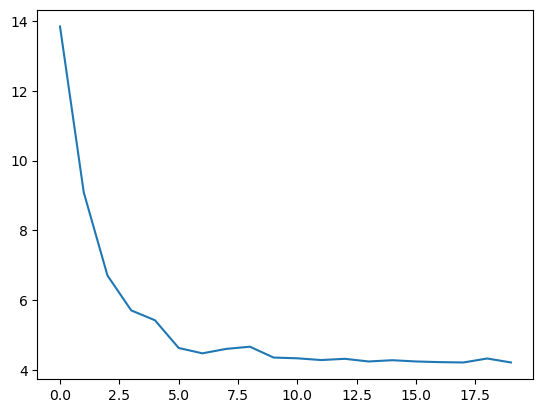

In [255]:
n_epochs = 20   # number of epochs to run
batch_size = 1500  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch.to(device))
            loss = loss_fn(y_pred.to(device), y_batch.to(device))
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test.to(device))
    mse = loss_fn(y_pred.to(device), y_test.to(device))
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [5]:
def get_score_by_parameter(predict_field, X, Y):
    df = pd.merge(X, Y, on=["engine_id", "flight_datetime", "flight_phase"])
    df = df[df[predict_field].notna()]
    df = df.fillna(-100)
    X = df.drop(columns=[predict_field])
    X = X.drop(columns=[
        "engine_id", "aircraft_id", "flight_datetime",
        "flight_phase", "engine_family", "engine_type", "manufacturer",
        "aircraft_family", "aircraft_type", "aircraft_grp", "ac_manufacturer"])
    y = df[predict_field]
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    model = CatBoostRegressor(iterations=100, verbose=False)
    model.fit(X_train, y_train)
    catboost_predicted = model.predict(X_test)
    catboost_score = mean_squared_error(y_test, catboost_predicted, squared=False)
    catboost_predicted = model.predict(X)
    return catboost_score

In [15]:
scores = pd.DataFrame(columns=["parameter", "rmse", ".0", ".1", ".5", ".9", "1"])
output_parameters = Y.columns.drop(['flight_datetime', 'flight_phase', 'engine_id'])

for param in tqdm(output_parameters):
    try:
        score = get_score_by_parameter(param, X, Y)
        print(score)
        qua = df[param].quantile([.0, .1, .5, .9, 1])
        qua = list(qua)
        scores.loc[len(scores)] = [param, score] + qua
    except:
        continue

  3%|██▊                                                                                | 1/30 [00:01<00:56,  1.95s/it]

0.005946267947807024


  7%|█████▌                                                                             | 2/30 [00:03<00:44,  1.60s/it]

2.3935944440289703


 10%|████████▎                                                                          | 3/30 [00:03<00:31,  1.18s/it]

0.195889760551806


 13%|███████████                                                                        | 4/30 [00:04<00:25,  1.01it/s]

0.1329126821253134


 17%|█████████████▊                                                                     | 5/30 [00:05<00:22,  1.09it/s]

0.059973910172477475


 20%|████████████████▌                                                                  | 6/30 [00:06<00:22,  1.05it/s]

0.10359699864487969


 23%|███████████████████▎                                                               | 7/30 [00:07<00:25,  1.09s/it]

1.8250299555854523


 27%|██████████████████████▏                                                            | 8/30 [00:09<00:28,  1.28s/it]

1.0137242526569923


 30%|████████████████████████▉                                                          | 9/30 [00:10<00:25,  1.21s/it]

0.20597332723061373


 33%|███████████████████████████▎                                                      | 10/30 [00:11<00:23,  1.15s/it]

1.120428839292808


 37%|██████████████████████████████                                                    | 11/30 [00:12<00:21,  1.11s/it]

0.02595125670094445


 40%|████████████████████████████████▊                                                 | 12/30 [00:14<00:21,  1.19s/it]

0.052175962572176625


 43%|███████████████████████████████████▌                                              | 13/30 [00:15<00:20,  1.23s/it]

0.5012068355836108


 47%|██████████████████████████████████████▎                                           | 14/30 [00:17<00:23,  1.46s/it]

0.1398437184224504


 50%|█████████████████████████████████████████                                         | 15/30 [00:19<00:22,  1.53s/it]

0.10249780204536779


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:19<00:17,  1.28s/it]

0.11145537344669908


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:20<00:14,  1.11s/it]

0.24959327035621837


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:22<00:16,  1.38s/it]

0.1662457976114745


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:23<00:15,  1.37s/it]

0.06252526060188085


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:25<00:14,  1.45s/it]

0.3439156205825444


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:26<00:11,  1.33s/it]

0.05978245906041602


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:27<00:06,  1.01it/s]

0.5453657163014298


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:29<00:06,  1.10s/it]

0.0036691489404235608


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:30<00:05,  1.18s/it]

13.95641499813017


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:32<00:05,  1.43s/it]

0.635317381630894


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:34<00:04,  1.62s/it]

6.591105241332177


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:35<00:02,  1.33s/it]

0.09377664078794708


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:35<00:01,  1.16s/it]

2.2286868068571786


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:37<00:00,  1.25s/it]

128.1615746408957


In [10]:
scores

,parameter,rmse,.0,.1,.5,.9,1
